In [1]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# BigFrames Timedelta

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/googleapis/python-bigquery-dataframes/blob/main/notebooks/data_types/timedelta.ipynb">
      <img src="https://raw.githubusercontent.com/googleapis/python-bigquery-dataframes/refs/heads/main/third_party/logo/colab-logo.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/googleapis/python-bigquery-dataframes/blob/main/notebooks/data_types/timedelta.ipynb">
      <img src="https://raw.githubusercontent.com/googleapis/python-bigquery-dataframes/refs/heads/main/third_party/logo/github-logo.png" width="32" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/googleapis/python-bigquery-dataframes/blob/main/notebooks/data_types/timedelta.ipynb">
      <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTW1gvOovVlbZAIZylUtf5Iu8-693qS1w5NJw&s" alt="BQ logo" width="35">
      Open in BQ Studio
    </a>
  </td>
</table>

In this notebook, you will use timedeltas to analyze the taxi trips in NYC. 

# Setup

In [2]:
import bigframes.pandas as bpd

PROJECT = "bigframes-dev" # replace this with your project
LOCATION = "us" # replace this with your location

bpd.options.bigquery.project = PROJECT
bpd.options.bigquery.location = LOCATION
bpd.options.display.progress_bar = None

bpd.options.bigquery.ordering_mode = "partial"

# Timedelta arithmetics and comparisons

First, you load the taxi data from the BigQuery public dataset `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2021`. The size of this table is about 6.3 GB.

In [3]:
taxi_trips = bpd.read_gbq("bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2021").dropna()
taxi_trips = taxi_trips[taxi_trips['pickup_datetime'].dt.year == 2021]
taxi_trips.peek(5)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,airport_fee,total_amount,pickup_location_id,dropoff_location_id,data_file_year,data_file_month
0,1,2021-06-09 07:44:46+00:00,2021-06-09 07:45:24+00:00,1,2.200000000,1.0,N,4,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,263,263,2021,6
1,2,2021-06-07 11:59:46+00:00,2021-06-07 12:00:00+00:00,2,0.010000000,3.0,N,2,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,263,263,2021,6
2,2,2021-06-23 15:03:58+00:00,2021-06-23 15:04:34+00:00,1,0E-9,1.0,N,1,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,193,193,2021,6
3,1,2021-06-12 14:26:55+00:00,2021-06-12 14:27:08+00:00,0,1.000000000,1.0,N,3,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,143,143,2021,6
4,2,2021-06-15 08:39:01+00:00,2021-06-15 08:40:36+00:00,1,0E-9,1.0,N,1,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,193,193,2021,6


Based on the dataframe content, you calculate the trip durations and store them under the column “trip_duration”. You can see that the values under "trip_duartion" are timedeltas.

In [4]:
taxi_trips['trip_duration'] = taxi_trips['dropoff_datetime'] - taxi_trips['pickup_datetime']
taxi_trips['trip_duration'].dtype

duration[us][pyarrow]

To remove data outliers, you filter the taxi_trips to keep only the trips that were less than 2 hours.

In [5]:
import pandas as pd

taxi_trips = taxi_trips[taxi_trips['trip_duration'] <= pd.Timedelta("2h")]

Finally, you calculate the average speed of each trip, and find the median speed of all trips.

In [6]:
average_speed = taxi_trips["trip_distance"] / (taxi_trips['trip_duration'] / pd.Timedelta("1h"))
print(f"The median speed of an average taxi trip is: {average_speed.median():.2f} mph.")

The median speed of an average taxi trip is: 10.58 mph.


Given how packed NYC is, a median taxi speed of 10.58 mph totally makes sense.

# Use timedelta for rolling aggregation

Using your existing dataset, you can now calculate the taxi trip count over a period of two days, and find out when NYC is at its busiest and when it is fast asleep.

First, you pick two workdays (a Thursday and a Friday) as your target dates:

In [7]:
import datetime

target_dates = [
    datetime.date(2021, 12, 2), 
    datetime.date(2021, 12, 3)
]

two_day_taxi_trips = taxi_trips[taxi_trips['pickup_datetime'].dt.date.isin(target_dates)]
print(f"Number of records: {len(two_day_taxi_trips)}")
# Number of records: 255434


Number of records: 255434


Your next step involves aggregating the number of records associated with each unique "pickup_datetime" value. Additionally, the data undergo upsampling to account for any absent timestamps, which are populated with a count of 0.

In [8]:
import pandas as pd

two_day_trip_count = two_day_taxi_trips['pickup_datetime'].value_counts()

full_index = pd.date_range(
    start='2021-12-02 00:00:00',
    end='2021-12-04 00:00:00',
    freq='s',
    tz='UTC'
)
two_day_trip_count = two_day_trip_count.reindex(full_index).fillna(0)

You'll then calculate the sum of trip counts within a 5-minute rolling window. This involves using the `rolling()` method, which can accept a time window in the form of either a string or a timedelta object.

In [9]:
two_day_trip_rolling_count = two_day_trip_count.sort_index().rolling(window="5m").sum()

Finally, you visualize the trip counts throughout the target dates.

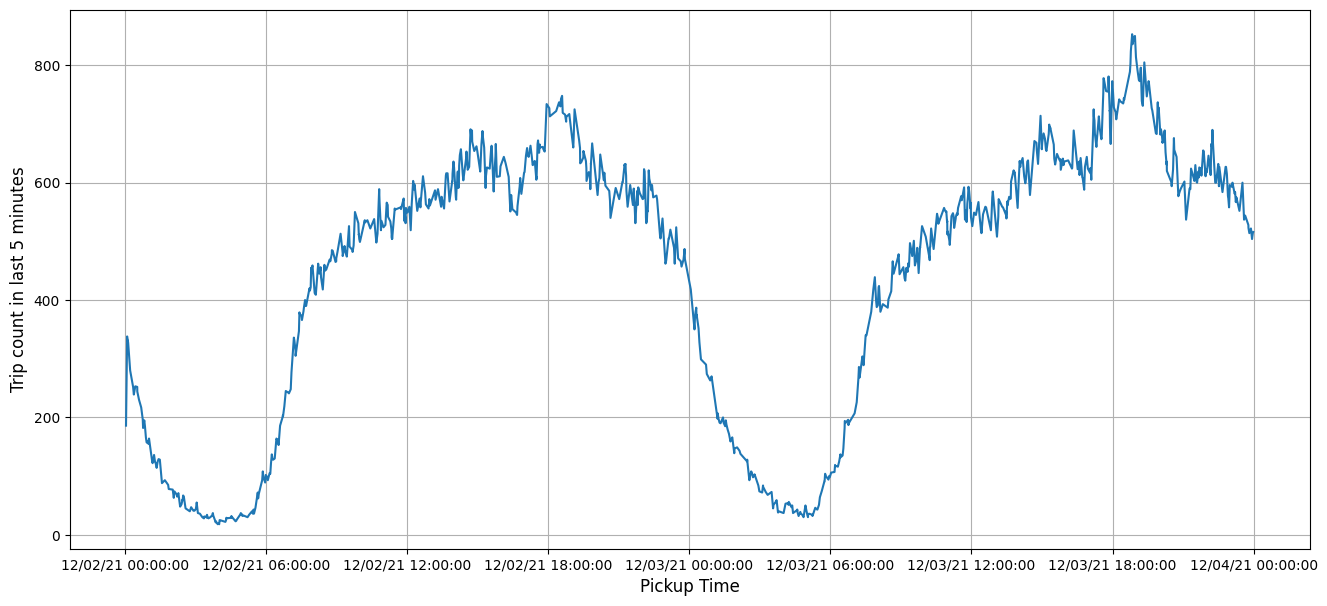

In [10]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(16,7))
ax = plt.gca()
formatter = mdates.DateFormatter("%D %H:%M:%S")
ax.xaxis.set_major_formatter(formatter)

ax.tick_params(axis='both', labelsize=10)

two_day_trip_rolling_count.plot(ax=ax, legend=False)
plt.xlabel("Pickup Time", fontsize=12)
plt.ylabel("Trip count in last 5 minutes", fontsize=12)
plt.grid()
plt.show()


The taxi ride count reached its lowest point around 5:00 a.m., and peaked around 7:00 p.m. on a workday. Such is the rhythm of NYC.